# Toy Examples

synthetic data experiments to test the spherical projection GP approach


In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
import matplotlib.pyplot as plt
from src.experiments import run_exact_proj_svgp
from src.config import TrainCfg


## 1D Toy Example - Single Mixture


train: 700, test: 300
running exact GP training | iters=500 lr=0.02 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=4.188419 Delta=inf ||grad||=1.59e+01
noise=0.0981 |raw_noise|grad=0.3389677107334137
[exact] iter=0100 loss=0.858513 Delta=6.08e-03 ||grad||=8.46e-01
noise=0.0167 |raw_noise|grad=0.18139290809631348
[exact] iter=0200 loss=0.115699 Delta=6.12e-03 ||grad||=7.63e-01
noise=0.00903 |raw_noise|grad=0.002373621566221118
[exact] iter=0300 loss=-0.322993 Delta=3.11e-03 ||grad||=4.87e-01
noise=0.00893 |raw_noise|grad=0.0012328044977039099
[exact] iter=0400 loss=-0.532995 Delta=1.09e-03 ||grad||=2.75e-01
noise=0.00898 |raw_noise|grad=0.0012070651864632964
[exact] done | time=5.41s best_loss=-0.621818

running spherical GP training | iters=500 lr=0.02 d=300 jitter=0.0001
[proj ] iter=0000 loss=12.368922 Delta=inf ||grad||=2.51e+00
noise=0.1 |raw_noise|grad=0.19080574810504913
[proj ] iter=0100 loss=9.664802 Delta=1.54e-02 ||grad||=1.13e+00
noise=0.119 |raw_noise|grad=0.1131439283490

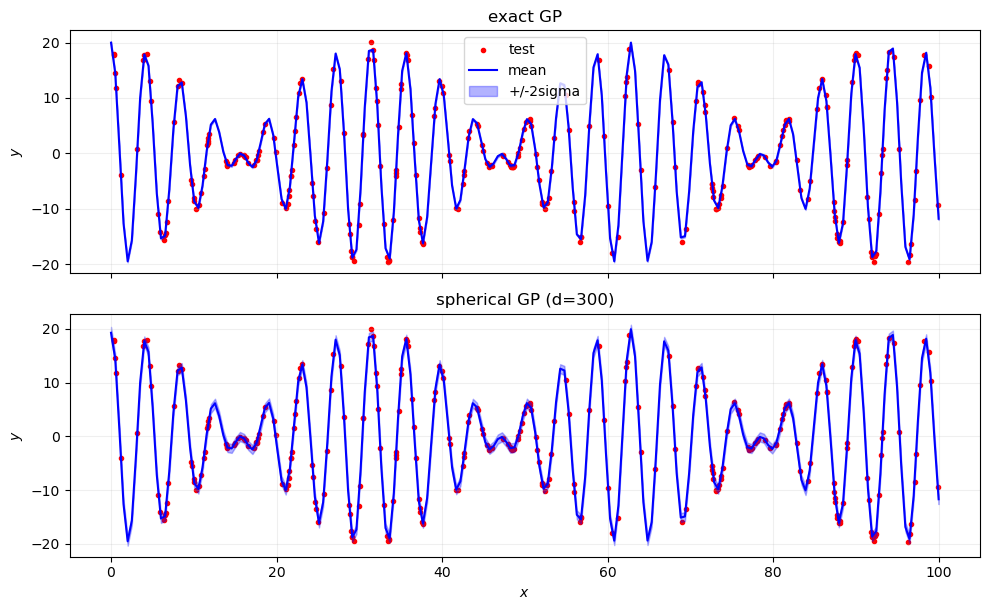

In [2]:
# generate toy data with periodic structure
torch.manual_seed(0)
np.random.seed(0)
N = 1000
x = 100 * np.random.rand(N) + 0.1 * np.random.randn(N)
y = 20 * np.cos(1.5 * x) * np.cos(0.1 * x) + 0.1 * np.random.randn(N)
x_plot = np.linspace(0, 100, 200)

n_train = int(0.7*N)

x_train = torch.tensor(x[:n_train], dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_test = torch.tensor(x[n_train:], dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y[n_train:], dtype=torch.float32)

print(f"train: {len(x_train)}, test: {len(x_test)}")

d_proj = 300
run_exact_proj_svgp(x_train, y_train, x_test, y_test, d_proj=d_proj, num_mixtures=1,
                    x_plot=x_plot, add_svgp=False, init_hyps_data=False,
                    savepath='../results/toy_1d_single_mixture.png')


## 1D Toy Example - Two Mixtures


running exact GP training | iters=500 lr=0.02 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=10.990931 Delta=inf ||grad||=3.23e+01
noise=0.102 |raw_noise|grad=0.30484697222709656
[exact] iter=0100 loss=1.481538 Delta=5.21e-03 ||grad||=9.08e-01
noise=0.0271 |raw_noise|grad=0.12722358107566833
[exact] iter=0200 loss=1.119920 Delta=2.75e-03 ||grad||=7.38e-01
noise=0.00838 |raw_noise|grad=0.012636019848287106
[exact] iter=0300 loss=0.815271 Delta=3.49e-03 ||grad||=7.64e-01
noise=0.00855 |raw_noise|grad=0.0016945679672062397
[exact] iter=0400 loss=0.472281 Delta=3.45e-03 ||grad||=7.03e-01
noise=0.00902 |raw_noise|grad=0.002468572463840246
[exact] done | time=8.12s best_loss=0.187639

running spherical GP training | iters=500 lr=0.02 d=300 jitter=0.0001
[proj ] iter=0000 loss=6.670431 Delta=inf ||grad||=5.90e-01
noise=0.1 |raw_noise|grad=0.031700994819402695
[proj ] iter=0100 loss=5.719371 Delta=5.65e-03 ||grad||=2.85e-01
noise=0.119 |raw_noise|grad=0.01959669031202793
[proj ] iter=0200 lo

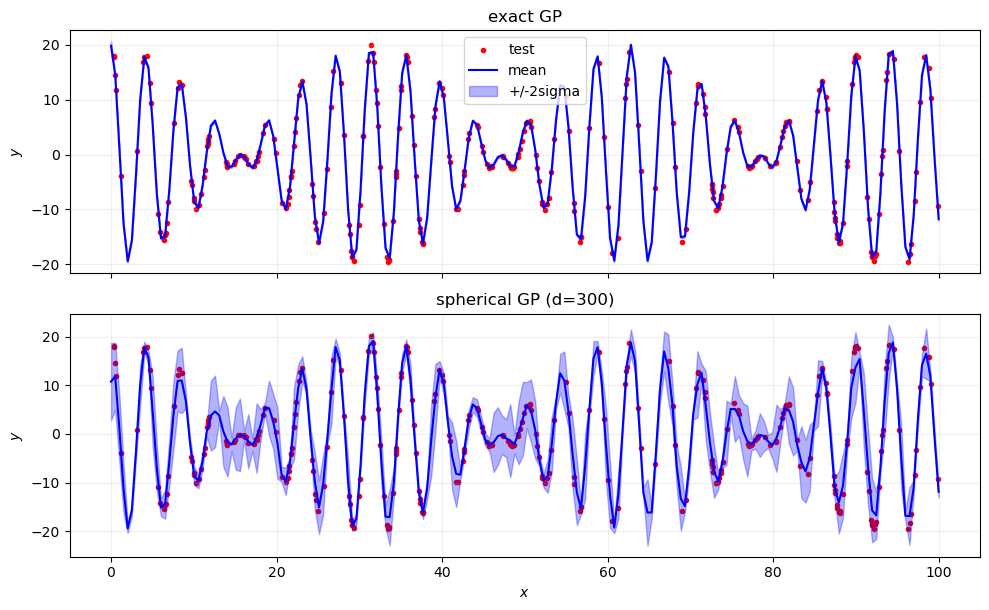

In [3]:
# same data but with 2 spectral mixture components
d_proj = 300
run_exact_proj_svgp(x_train, y_train, x_test, y_test, d_proj=d_proj, num_mixtures=2,
                    x_plot=x_plot, add_svgp=False, init_hyps_data=False,
                    savepath='../results/toy_1d_two_mixtures.png')


## 1D Toy with Gap (Extrapolation Test)


train: 632, gap test: 96
running exact GP training | iters=500 lr=0.02 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=11.253949 Delta=inf ||grad||=3.25e+01
noise=0.102 |raw_noise|grad=0.28004559874534607
[exact] iter=0100 loss=1.534056 Delta=5.47e-03 ||grad||=9.57e-01
noise=0.0267 |raw_noise|grad=0.12445228546857834
[exact] iter=0200 loss=1.130330 Delta=3.36e-03 ||grad||=8.19e-01
noise=0.0081 |raw_noise|grad=0.014409528113901615
[exact] iter=0300 loss=0.794286 Delta=3.30e-03 ||grad||=7.43e-01
noise=0.00789 |raw_noise|grad=0.0033668368123471737
[exact] iter=0400 loss=0.450941 Delta=3.31e-03 ||grad||=6.93e-01
noise=0.00855 |raw_noise|grad=0.002978553529828787
[exact] done | time=5.76s best_loss=0.190498

running spherical GP training | iters=500 lr=0.02 d=300 jitter=0.0001
[proj ] iter=0000 loss=7.349765 Delta=inf ||grad||=8.30e-01
noise=0.1 |raw_noise|grad=0.0376274548470974
[proj ] iter=0100 loss=6.025940 Delta=6.42e-03 ||grad||=3.55e-01
noise=0.119 |raw_noise|grad=0.0217665769159793

/Users/arkin/anaconda3/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


[SVGP] epoch  200/1500: loss=93.281097, Delta_loss=3.88e-01, gradnorm=3.93e+01
[SVGP] epoch  400/1500: loss=49.923626, Delta_loss=8.81e-02, gradnorm=1.92e+01
[SVGP] epoch  600/1500: loss=36.037560, Delta_loss=4.77e-02, gradnorm=1.30e+01
[SVGP] epoch  800/1500: loss=27.305332, Delta_loss=3.44e-02, gradnorm=9.41e+00
[SVGP] epoch 1000/1500: loss=21.941767, Delta_loss=2.39e-02, gradnorm=7.19e+00
[SVGP] epoch 1200/1500: loss=17.101652, Delta_loss=1.72e-02, gradnorm=8.57e+00
[SVGP] epoch 1400/1500: loss=14.104721, Delta_loss=1.07e-02, gradnorm=3.66e+00
[SVGP] epoch 1500/1500: loss=13.202451, Delta_loss=7.81e-03, gradnorm=3.18e+00
                   GPyTorch (exact)           GPyTorch (proj)  \
weight         [15.224369, 4.78604]     [11.486591, 6.982694]   
scale      [0.18431397, 0.12081662]  [0.24058469, 0.92988485]   
mean              [0.0, 0.26660514]         [0.0, 0.73540664]   
noise_var                  0.008632                  0.129564   

                     GPyTorch (SVGP)  
wei

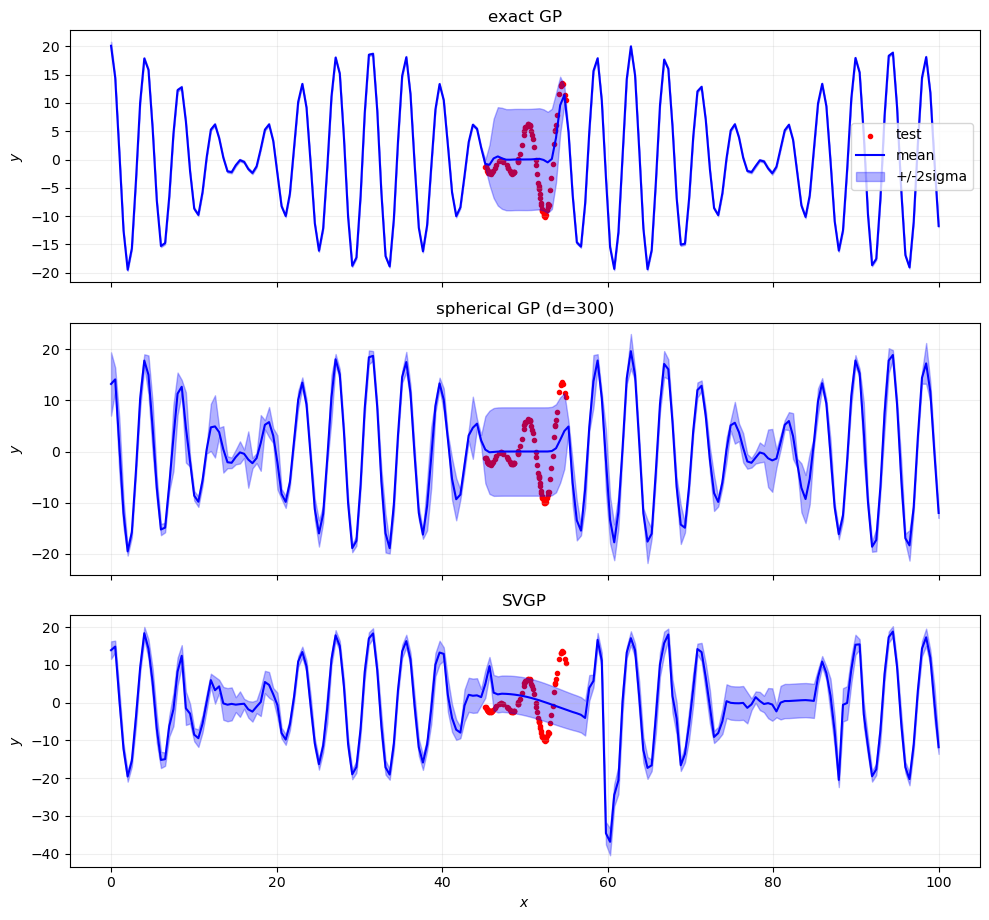

In [4]:
# create a gap in the training data to test extrapolation
torch.manual_seed(0)
np.random.seed(0)
N = 1000
x = 100 * np.random.rand(N) + 0.1 * np.random.randn(N)
y = 20 * np.cos(1.5 * x) * np.cos(0.1 * x) + 0.1 * np.random.randn(N)
x_plot = np.linspace(0, 100, 200)

# define a contiguous input gap
gap_mask = (x >= 45.0) & (x <= 55.0)
x_gap, y_gap = x[gap_mask], y[gap_mask]           # test (gap-extrapolation)
x_nogap, y_nogap = x[~gap_mask], y[~gap_mask]     # pool for training + interp-test

# split only the non-gap pool into train / interp-test
perm = np.random.permutation(len(x_nogap))
frac_train = 0.7
n_train_out = int(frac_train * len(x_nogap))

x_train = torch.tensor(x_nogap[perm[:n_train_out]], dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_nogap[perm[:n_train_out]], dtype=torch.float32)

x_test_interp = torch.tensor(x_nogap[perm[n_train_out:]], dtype=torch.float32).unsqueeze(-1)
y_test_interp = torch.tensor(y_nogap[perm[n_train_out:]], dtype=torch.float32)

x_test_gap = torch.tensor(x_gap, dtype=torch.float32).unsqueeze(-1)
y_test_gap = torch.tensor(y_gap, dtype=torch.float32)

print(f"train: {len(x_train)}, gap test: {len(x_test_gap)}")

d_proj = 300
# gap-extrapolation metrics (test solely inside [45,55])
run_exact_proj_svgp(x_train, y_train, x_test_gap, y_test_gap, d_proj=d_proj, num_mixtures=2,
                    x_plot=x_plot, add_svgp=True, init_hyps_data=False,
                    savepath='../results/toy_1d_gap_extrapolation.png')


## 2D Toy Example


In [5]:
def f_true_xy(x):
    # x: (..., 2) tensor
    x1, x2 = x[..., 0], x[..., 1]
    return (2.5*torch.sin(1.2*x1)*torch.cos(0.7*x2)
            + 0.3*x1 - 0.2*x2 + 0.8*torch.sin(0.3*(x1+x2)))

def make_toy2d(N=1200, noise=0.2, seed=0):
    rng = np.random.RandomState(seed)
    X = np.column_stack([rng.uniform(0.0, 10.0, N),
                         rng.uniform(0.0, 10.0, N)])
    X_t = torch.tensor(X, dtype=torch.float32)
    y_clean = f_true_xy(X_t)
    y = y_clean + noise*torch.randn_like(y_clean)
    # random split 80/20
    idx = rng.permutation(N)
    n_tr = int(0.8*N)
    tr, te = idx[:n_tr], idx[n_tr:]
    x_train = X_t[tr]; y_train = y[tr]
    x_test  = X_t[te]; y_test  = y[te]
    return x_train, y_train, x_test, y_test

def make_grid_2d(xmin=0.0, xmax=10.0, ymin=0.0, ymax=10.0, G=120):
    x1 = np.linspace(xmin, xmax, G)
    x2 = np.linspace(ymin, ymax, G)
    X1g, X2g = np.meshgrid(x1, x2)              # shape (G,G)
    Xg = np.c_[X1g.ravel(), X2g.ravel()]        # shape (G*G, 2)
    return torch.tensor(Xg, dtype=torch.float32), (G, G), (xmin, xmax, ymin, ymax)


train: 960, test: 240
running exact GP training | iters=500 lr=0.02 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=1.790466 Delta=inf ||grad||=4.41e-01
noise=0.0981 |raw_noise|grad=0.025719599798321724
[exact] iter=0100 loss=0.204948 Delta=8.33e-03 ||grad||=7.95e-02
noise=0.0364 |raw_noise|grad=0.001005515456199646
[exact] iter=0200 loss=0.138138 Delta=1.72e-02 ||grad||=1.96e-02
noise=0.0344 |raw_noise|grad=0.0017056672368198633
[exact] early stop @ 230
[exact] done | time=13.66s best_loss=0.086753

running spherical GP training | iters=500 lr=0.02 d=400 jitter=0.0001
[proj ] iter=0000 loss=2.150923 Delta=inf ||grad||=2.13e-01
noise=0.0998 |raw_noise|grad=0.0035908569116145372
[proj ] iter=0100 loss=2.007215 Delta=2.37e-04 ||grad||=7.37e-03
noise=0.0944 |raw_noise|grad=0.00016762493760325015
[proj] early stop @ 116
[proj ] done | time=6.98s best_loss=1.967896

running SVGP training | steps=1500 inducing points=128 lr=0.003
[SVGP] epoch  200/1500: loss=65.128258, Delta_loss=4.08e-01, 

FileNotFoundError: [Errno 2] No such file or directory: 'results/gp_comparison_2d_d400_mixtures4_with_svgp.png'

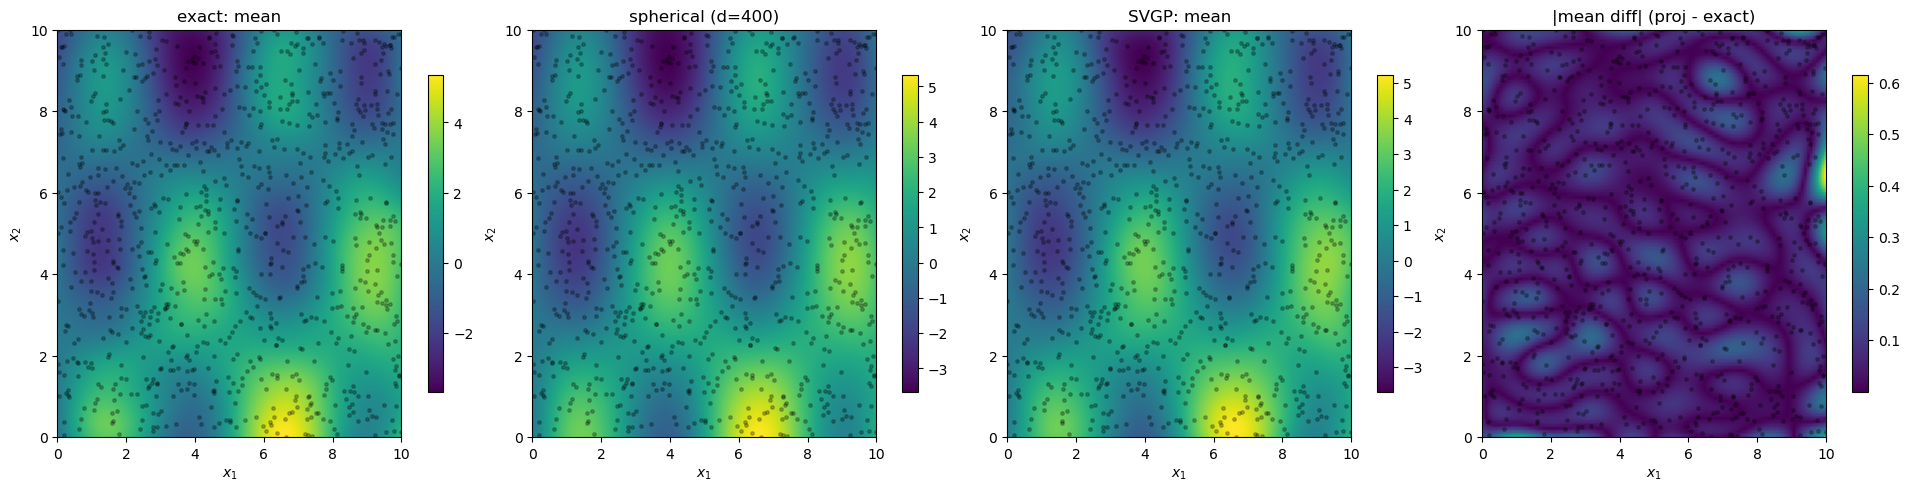

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

# generate toy-2D and grid
x_train, y_train, x_test, y_test = make_toy2d(N=1200, noise=0.2, seed=0)
x_grid, grid_shape, extent = make_grid_2d(0.0, 10.0, 0.0, 10.0, G=120)

print(f"train: {len(x_train)}, test: {len(x_test)}")

d_proj = 400
run_exact_proj_svgp(x_train, y_train, x_test, y_test, x_grid=x_grid, d_proj=d_proj, num_mixtures=4,
                   add_svgp=True, init_hyps_data=False, grid_shape=grid_shape, extent=extent,
                   savepath='../results/toy_2d_four_mixtures_with_svgp.png')
